In [1]:
import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 220500
overlap = 0

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db = '../../FSDKaggle2018/'

In [5]:
ps = Audio_Processor(path_to_db + 'train/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/train.csv')
classes = dataset.label.unique()
dataset = dataset.drop(['manually_verified', 'freesound_id', 'license'], axis=1)
print(dataset.head())

          fname         label
0  00044347.wav        Hi-hat
1  001ca53d.wav     Saxophone
2  002d256b.wav       Trumpet
3  0033e230.wav  Glockenspiel
4  00353774.wav         Cello


In [7]:
h_classes = ['Human & Animal', 'Interacting Materials', 'Musical Instruments']
mapping = {'Hi-hat': h_classes[2],'Saxophone': h_classes[2],'Trumpet': h_classes[2],
           'Glockenspiel': h_classes[2],'Cello': h_classes[2],'Knock': h_classes[1],
           'Gunshot_or_gunfire': h_classes[1],'Clarinet': h_classes[2],'Computer_keyboard': h_classes[1],
           'Keys_jangling': h_classes[1],'Snare_drum': h_classes[2],'Writing': h_classes[1],
           'Laughter': h_classes[0],'Tearing': h_classes[1],'Fart': h_classes[1],'Oboe': h_classes[2],
           'Flute': h_classes[2],'Cough': h_classes[0], 'Telephone': h_classes[1], 'Bark': h_classes[0],
           'Chime': h_classes[2],'Bass_drum': h_classes[2],'Bus': h_classes[1], 'Squeak': h_classes[0],
           'Scissors': h_classes[1],'Harmonica': h_classes[2],'Gong': h_classes[2],'Microwave_oven': h_classes[1],
           'Burping_or_eructation': h_classes[0],'Double_bass': h_classes[2],'Shatter': h_classes[1],
           'Fireworks': h_classes[1], 'Tambourine': h_classes[2], 'Cowbell': h_classes[2], 'Electric_piano': h_classes[2],
           'Meow': h_classes[0], 'Drawer_open_or_close': h_classes[1], 'Applause': h_classes[1], 'Acoustic_guitar': h_classes[2],
           'Violin_or_fiddle': h_classes[2], 'Finger_snapping': h_classes[1]
            }

In [8]:
from data_utils import enumerate_strings
dataset['h_category'] = None
for index, row in dataset.iterrows():
    row['target'] = np.where(classes == row['label'])
    dataset.loc[index, 'h_category'] = mapping[row['label']]
dataset.columns = ['filename', 'target', 'h_category']

In [9]:
enum_map = enumerate_strings(dataset, ['filename'])

In [10]:
dataset.head()

,filename,target,h_category
0,00044347.wav,23,2
1,001ca53d.wav,30,2
2,002d256b.wav,38,2
3,0033e230.wav,19,2
4,00353774.wav,6,2


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [11]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=None, 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 77ms/step - loss: 1.2490
Epoch 1/1
2/2 [==============================] - 0s 61ms/step - loss: 1.3341
	Bytes: 16910096
	Processing Time: 332.36981225013733


In [12]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,18222.000000,18222.000000,18222.000000,18222.000000,18222.000000,18222.000000,18222.000000,18222.000000,18222.000000,18222.000000,...,1.822200e+04,1.822200e+04,1.822200e+04,18222.000000,1.822200e+04,18222.000000,18222.000000,18222.000000,18222.000000,18222.000000
mean,0.375053,0.347806,0.224131,0.182045,0.160871,0.142232,0.132101,0.131963,0.123560,0.118974,...,7.735157e-06,4.717090e-06,-1.100088e-05,-0.000009,-4.992756e-06,0.000009,0.000016,0.000017,1.308912,19.675612
std,0.187704,0.164944,0.093299,0.074428,0.068584,0.059889,0.056583,0.056911,0.053612,0.054338,...,1.708941e-03,1.689558e-03,1.701211e-03,0.001699,1.691888e-03,0.001686,0.001693,0.001700,0.728652,12.664897
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.825422e-02,-6.926859e-02,-6.926861e-02,-0.081712,-8.171195e-02,-0.059185,-0.048254,-0.069269,0.000000,0.000000
25%,0.237022,0.230735,0.170046,0.136809,0.118877,0.105949,0.097490,0.094810,0.090518,0.084657,...,-4.627338e-05,-2.918305e-05,-4.025673e-05,-0.000030,-3.659044e-05,-0.000030,-0.000033,-0.000031,1.000000,8.000000
50%,0.371514,0.350901,0.226289,0.182683,0.156328,0.138778,0.127950,0.127679,0.118707,0.112826,...,-4.471541e-11,1.315517e-11,-1.924679e-11,0.000000,-8.023243e-12,0.000000,0.000000,0.000000,1.000000,20.000000
75%,0.511437,0.465834,0.279160,0.225749,0.199854,0.174745,0.161177,0.164637,0.150517,0.145909,...,2.691637e-05,4.045536e-05,2.665303e-05,0.000035,2.795723e-05,0.000034,0.000028,0.000030,2.000000,31.000000
max,0.907319,0.855296,0.750474,0.575756,0.533589,0.483655,0.486102,0.436268,0.435759,0.490008,...,8.171196e-02,8.171195e-02,8.171193e-02,0.065644,6.926860e-02,0.081712,0.081712,0.081712,2.000000,40.000000


In [13]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20, random_state=125)

In [14]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['l_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['l_target']

# Shallow Net
Separate into classes

In [15]:
from sklearn.model_selection import GridSearchCV
params = {
          'n_estimators': range(5,25,1),
          'criterion': ('gini', 'entropy')
         }

rfc = RandomForestClassifier()

clf = GridSearchCV(rfc, params, cv=5)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ('gini', 'entropy'), 'n_estimators': range(5, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

0.7519890260631001
Confusion matrix, without normalization
[[ 223  194  139]
 [  57 1057  269]
 [  52  193 1461]]


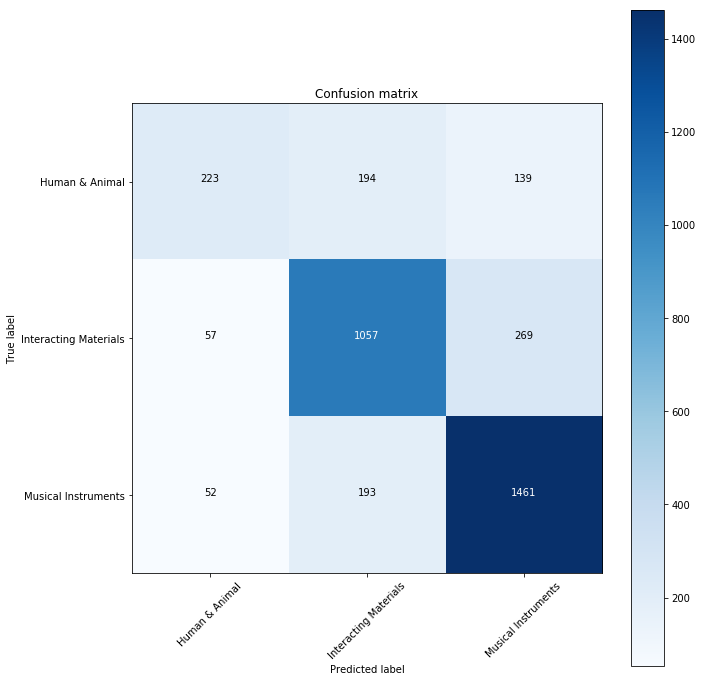

In [16]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [17]:
print(enum_map)

{'target': LabelEncoder(), 'h_category': LabelEncoder()}


In [18]:
import seaborn as sns
misclassified = {
    'h_target': [],
    'l_target': []
}

classes = enum_map['target'].inverse_transform(range(0,41))
print(classes)

for row, p, Y in zip(test.iterrows(), pred, test_y):
    if p != Y:
        misclassified['h_target'].append(classes[int(row[1]['h_target'])])
        misclassified['l_target'].append(h_classes[Y])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

['Acoustic_guitar' 'Applause' 'Bark' 'Bass_drum' 'Burping_or_eructation'
 'Bus' 'Cello' 'Chime' 'Clarinet' 'Computer_keyboard' 'Cough' 'Cowbell'
 'Double_bass' 'Drawer_open_or_close' 'Electric_piano' 'Fart'
 'Finger_snapping' 'Fireworks' 'Flute' 'Glockenspiel' 'Gong'
 'Gunshot_or_gunfire' 'Harmonica' 'Hi-hat' 'Keys_jangling' 'Knock'
 'Laughter' 'Meow' 'Microwave_oven' 'Oboe' 'Saxophone' 'Scissors'
 'Shatter' 'Snare_drum' 'Squeak' 'Tambourine' 'Tearing' 'Telephone'
 'Trumpet' 'Violin_or_fiddle' 'Writing']


,h_target,l_target
0,Bark,Human & Animal
1,Snare_drum,Musical Instruments
2,Snare_drum,Musical Instruments
3,Writing,Interacting Materials
4,Applause,Interacting Materials


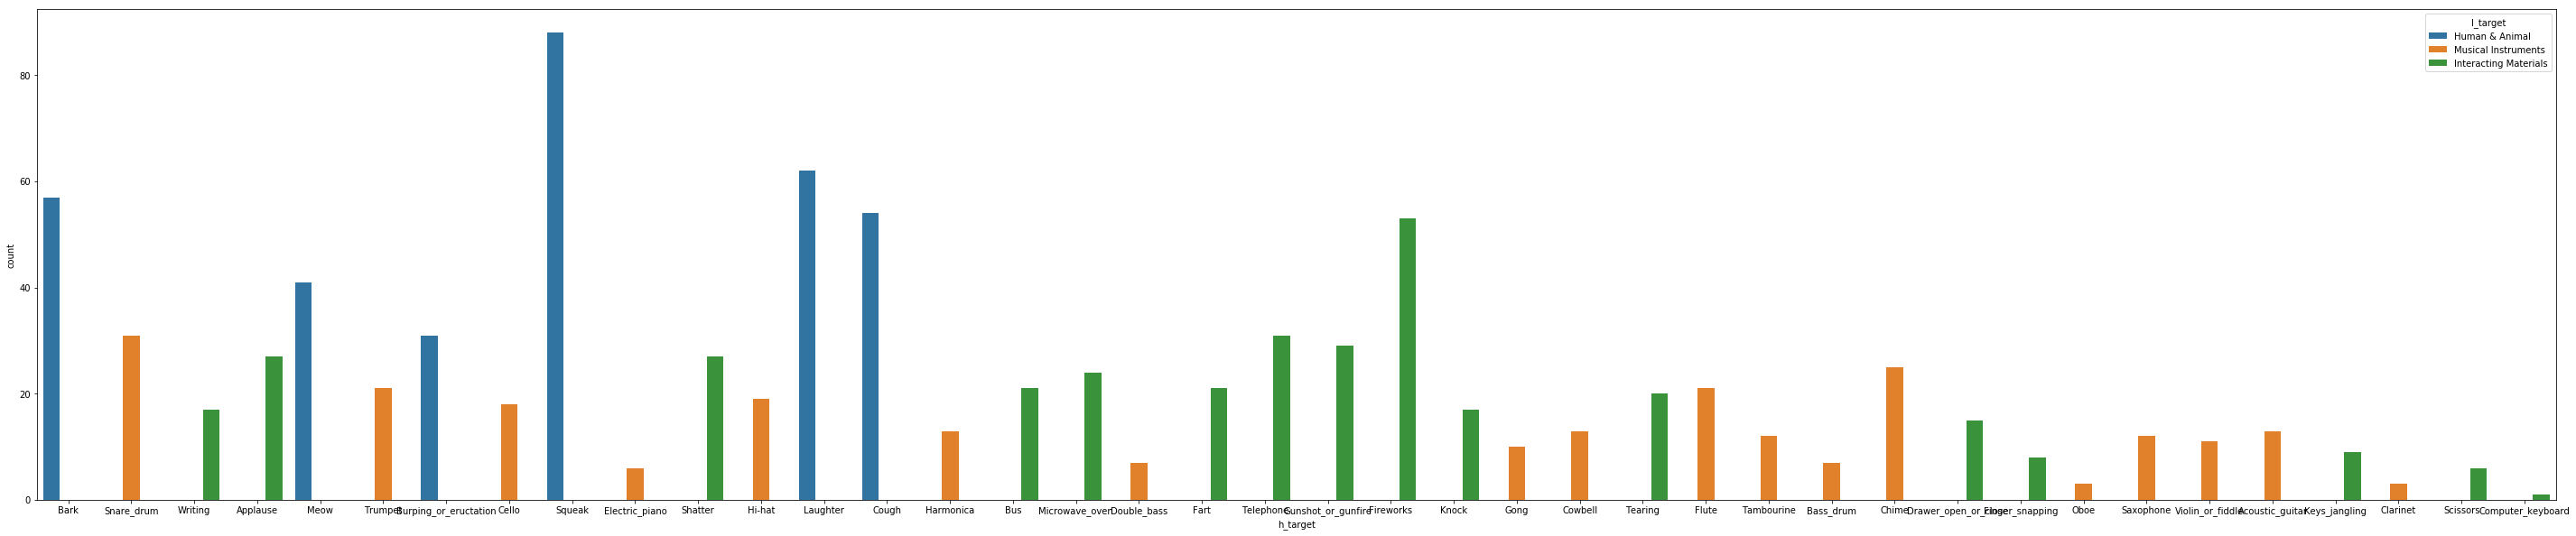

In [19]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='h_target', hue='l_target',data=misclassified)